# Contexts and their generation
## Scenario 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from utils.User_Classes import UserClass
from p4.Multi_TS_Learner import Multi_TS_Learner
from p4.Multi_UCB_Learner import Multi_UCB_Learner

from p4.feature_based_environment import Environment
from p4.ContextManager import ContextManager, ContextOptimizer

In [2]:
uc1 = UserClass(name = "C1")
uc2 = UserClass(name = "C2")
uc3 = UserClass(name = "C3")

user_classes = [uc1, uc2, uc3]

## Experiments

In [3]:


envs = {feature: Environment(feature) for feature in ['00', '01', '10', '11']}
opts = {feature: envs[feature].optimal for feature in ['00', '01', '10', '11']}
n_experiments = 2
T = 100
prices = [50, 100, 150, 200, 250]
bids = np.linspace(0.01, 3.0, 100)

no_context_ts_rewards_per_experiment = []
context_ts_rewards_per_experiment = []

no_context_ucb_rewards_per_experiment = []
context_ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    context_TS = ContextOptimizer(Multi_TS_Learner)
    nocontext_TS = Multi_TS_Learner(bids, prices)

    context_UCB = ContextOptimizer(Multi_UCB_Learner)
    nocontext_UCB = Multi_UCB_Learner(bids, prices)

    for t in range(0, T):
        if t % 10 == 0:
            print(f"{t} of experiment {e}")

        #context-generation using TS
        pulled_arms_per_feature = context_TS.pull_arms()
        optimizer_update_input = {}
        for feature in pulled_arms_per_feature.keys(): #.keys ritorna 00 01 10 11
            optimizer_update_input[feature] = pulled_arms_per_feature[feature] + envs[feature].round(*pulled_arms_per_feature[feature]) #ad ogni contesto assegno l'arm pullata sommata al round (perché la somma al round?)
        context_TS.update(optimizer_update_input) #e alla fine faccio l'update

        #context-generation using UCB
        pulled_arms_per_feature = context_UCB.pull_arms()
        optimizer_update_input = {}
        for feature in pulled_arms_per_feature.keys():
            optimizer_update_input[feature] = pulled_arms_per_feature[feature] + envs[feature].round(*pulled_arms_per_feature[feature])
        context_UCB.update(optimizer_update_input)


        #TS with no context generation
        pulled_arms = nocontext_TS.pull_arms()
        total_conversions = 0
        total_n_clicks = 0
        total_cum_cost = 0
        total_reward = 0
        for feature in ['00', '01', '10', '11']:
            n_conversions, n_clicks, cum_cost, reward = envs[feature].round(*pulled_arms)
            total_conversions += n_conversions
            total_n_clicks += n_clicks
            total_cum_cost += cum_cost
            total_reward += reward
        nocontext_TS.update(*pulled_arms, total_conversions, total_n_clicks, total_cum_cost, total_reward)

        # UCB
        pulled_arms = nocontext_UCB.pull_arms()
        total_conversions = 0
        total_n_clicks = 0
        total_cum_cost = 0
        total_reward = 0
        for feature in ['00', '01', '10', '11']:
            n_conversions, n_clicks, cum_cost, reward = envs[feature].round(*pulled_arms)
            total_conversions += n_conversions
            total_n_clicks += n_clicks
            total_cum_cost += cum_cost
            total_reward += reward
        nocontext_UCB.update(*pulled_arms, total_conversions, total_n_clicks, total_cum_cost, total_reward)

    context_ts_rewards_per_experiment.append(context_TS.collected_rewards)
    no_context_ts_rewards_per_experiment.append(nocontext_TS.collected_rewards)

    context_ucb_rewards_per_experiment.append(context_UCB.collected_rewards)
    no_context_ucb_rewards_per_experiment.append(nocontext_UCB.collected_rewards)

mean_cum_reward_ts_context = np.mean(context_ts_rewards_per_experiment, axis=0)
mean_cum_reward_ts_no_context = np.mean(no_context_ts_rewards_per_experiment, axis=0)

std_cum_reward_ts_context = np.std(context_ts_rewards_per_experiment, axis=0)
std_cum_reward_ts_no_context = np.std(no_context_ts_rewards_per_experiment, axis=0)

mean_cum_reward_ucb_context = np.mean(context_ucb_rewards_per_experiment, axis=0)
mean_cum_reward_ucb_no_context = np.mean(no_context_ucb_rewards_per_experiment, axis=0)

std_cum_reward_ucb_context = np.std(context_ucb_rewards_per_experiment, axis=0)
std_cum_reward_ucb_no_context = np.std(no_context_ucb_rewards_per_experiment, axis=0)

0 of experiment 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warn

10 of experiment 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  w

20 of experiment 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  w

30 of experiment 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


40 of experiment 0
50 of experiment 0
60 of experiment 0
70 of experiment 0
80 of experiment 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


90 of experiment 0
0 of experiment 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warn

10 of experiment 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  wa

20 of experiment 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  w

30 of experiment 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40 of experiment 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


50 of experiment 1
60 of experiment 1
70 of experiment 1
80 of experiment 1
90 of experiment 1


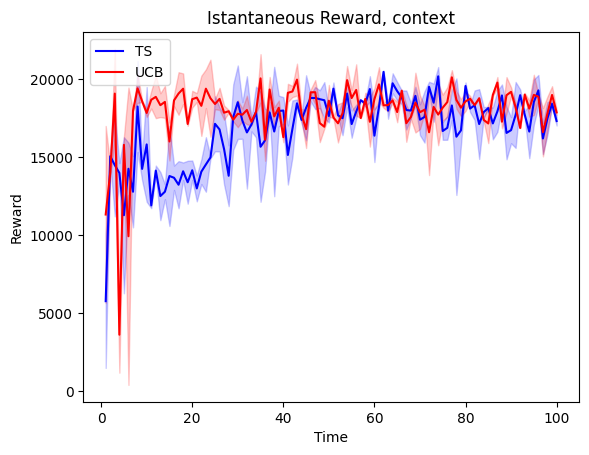

In [4]:
# CONTEXT TS REWARD IST
plt.plot(range(1, T+1), mean_cum_reward_ts_context, 'b', label='TS')
plt.fill_between(range(1, T+1), mean_cum_reward_ts_context - std_cum_reward_ts_context, mean_cum_reward_ts_context + std_cum_reward_ts_context, alpha=0.2, color='b')

plt.plot(range(1, T+1), mean_cum_reward_ucb_context, 'r', label='UCB')
plt.fill_between(range(1, T+1), mean_cum_reward_ucb_context - std_cum_reward_ucb_context, mean_cum_reward_ucb_context + std_cum_reward_ucb_context, alpha=0.2, color='r')

plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Istantaneous Reward, context')
plt.legend()
plt.show()

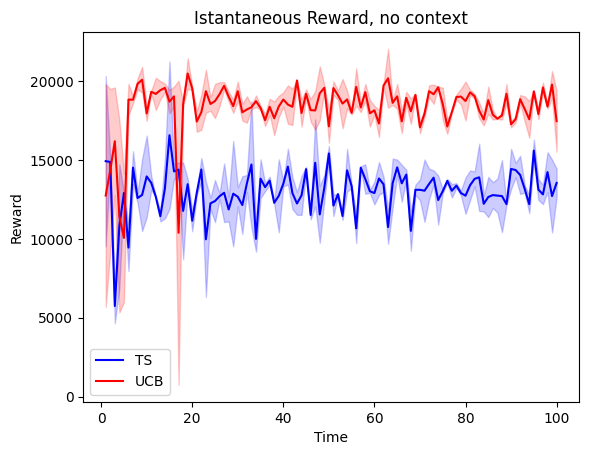

In [5]:
# NO CONTEXT TS REWARD IST
plt.plot(range(1, T+1), mean_cum_reward_ts_no_context, 'b', label='TS')
plt.fill_between(range(1, T+1), mean_cum_reward_ts_no_context - std_cum_reward_ts_no_context, mean_cum_reward_ts_no_context + std_cum_reward_ts_no_context, alpha=0.2, color='b')

plt.plot(range(1, T+1), mean_cum_reward_ucb_no_context, 'r', label='UCB')
plt.fill_between(range(1, T+1), mean_cum_reward_ucb_no_context - std_cum_reward_ucb_no_context, mean_cum_reward_ucb_no_context + std_cum_reward_ucb_no_context, alpha=0.2, color='r')

plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Istantaneous Reward, no context')
plt.legend()
plt.show()

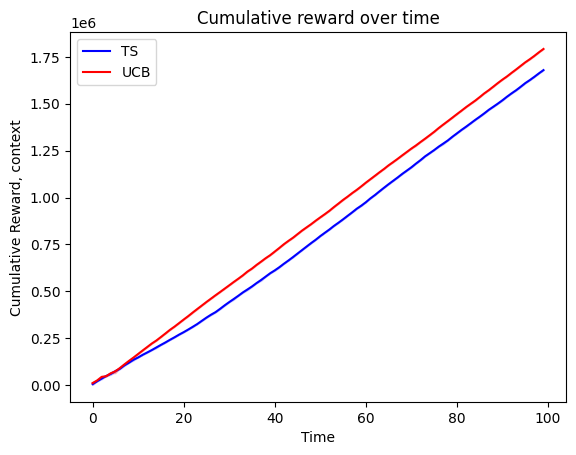

In [6]:
# CONTEXT TS REWARD CUM
plt.ylabel("Cumulative Reward, context")
plt.xlabel("Time")
plt.title("Cumulative reward over time")
plt.plot(np.cumsum(np.mean(context_ts_rewards_per_experiment, axis=0)), 'b', label='TS')
plt.fill_between(range(len(mean_cum_reward_ts_context)), np.cumsum(mean_cum_reward_ts_context) - std_cum_reward_ts_context, np.cumsum(mean_cum_reward_ts_context) + std_cum_reward_ts_context, alpha=0.2, color='b')

plt.plot(np.cumsum(np.mean(context_ucb_rewards_per_experiment, axis=0)), 'r', label='UCB')
plt.fill_between(range(len(mean_cum_reward_ucb_context)), np.cumsum(mean_cum_reward_ucb_context) - std_cum_reward_ucb_context, np.cumsum(mean_cum_reward_ucb_context) + std_cum_reward_ucb_context, alpha=0.2, color='r')

plt.legend()
plt.show()

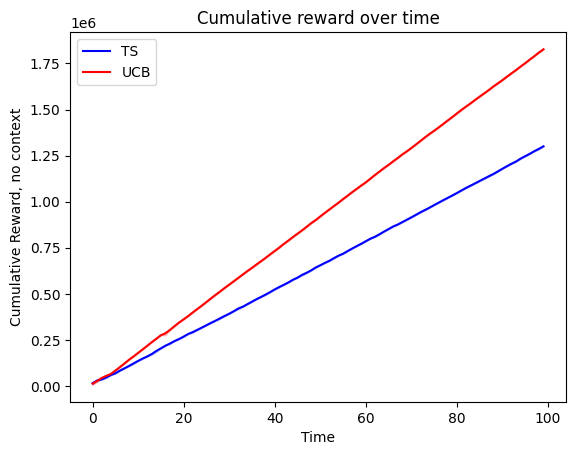

In [7]:
# NO CONTEXT TS REWARD CUM
plt.ylabel("Cumulative Reward, no context")
plt.xlabel("Time")
plt.title("Cumulative reward over time")
plt.plot(np.cumsum(np.mean(no_context_ts_rewards_per_experiment, axis=0)), 'b', label='TS')
plt.fill_between(range(len(mean_cum_reward_ts_no_context)), np.cumsum(mean_cum_reward_ts_no_context) - std_cum_reward_ts_no_context, np.cumsum(mean_cum_reward_ts_no_context) + std_cum_reward_ts_no_context, alpha=0.2, color='b')

plt.plot(np.cumsum(np.mean(no_context_ucb_rewards_per_experiment, axis=0)), 'r', label='UCB')
plt.fill_between(range(len(mean_cum_reward_ucb_no_context)), np.cumsum(mean_cum_reward_ucb_no_context) - std_cum_reward_ucb_no_context, np.cumsum(mean_cum_reward_ucb_no_context) + std_cum_reward_ucb_no_context, alpha=0.2, color='r')

plt.legend()
plt.show()

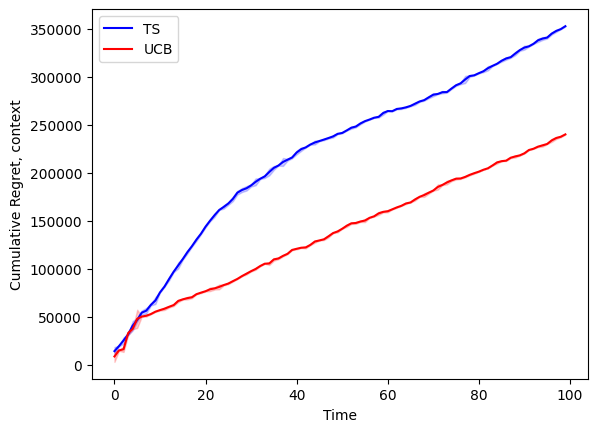

In [8]:
opts = {feature: envs[feature].optimal for feature in ['00', '01', '10', '11']}
opt = sum(opts.values())

#CONTEXT REGRET CUM
mean_cum_regret_ts = np.mean(opt - np.array(context_ts_rewards_per_experiment), axis=0)
std_cum_regret_ts = np.std(opt - np.array(context_ts_rewards_per_experiment), axis=0)

mean_cum_regret_ucb = np.mean(opt - np.array(context_ucb_rewards_per_experiment), axis=0)
std_cum_regret_ucb = np.std(opt - np.array(context_ucb_rewards_per_experiment), axis=0)

# Plot mean and standard deviation
plt.plot(np.cumsum(mean_cum_regret_ts), 'b', label='TS')
plt.fill_between(range(len(mean_cum_regret_ts)), np.cumsum(mean_cum_regret_ts) - std_cum_regret_ts, np.cumsum(mean_cum_regret_ts) + std_cum_regret_ts, alpha=0.2, color='b')

plt.plot(np.cumsum(mean_cum_regret_ucb), 'r', label='UCB')
plt.fill_between(range(len(mean_cum_regret_ucb)), np.cumsum(mean_cum_regret_ucb) - std_cum_regret_ucb, np.cumsum(mean_cum_regret_ucb) + std_cum_regret_ucb, alpha=0.2, color='r')

plt.ylabel("Cumulative Regret, context")
plt.xlabel("Time")
#plt.plot(np.cumsum(opt - np.array(mean_cum_reward_ts), axis=0), 'r')
plt.legend()
plt.show()

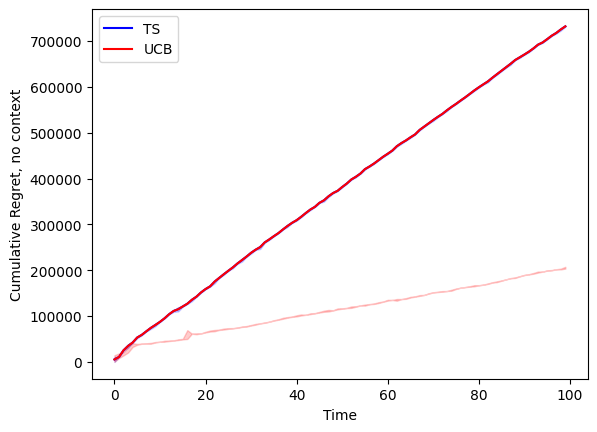

In [9]:
#NO CONTEXT REGRET CUM

mean_cum_regret_ts = np.mean(opt - np.array(no_context_ts_rewards_per_experiment), axis=0)
std_cum_regret_ts = np.std(opt - np.array(no_context_ts_rewards_per_experiment), axis=0)

mean_cum_regret_ucb = np.mean(opt - np.array(no_context_ucb_rewards_per_experiment), axis=0)
std_cum_regret_ucb = np.std(opt - np.array(no_context_ucb_rewards_per_experiment), axis=0)

# Plot mean and standard deviation
plt.plot(np.cumsum(mean_cum_regret_ts), 'b', label='TS')
plt.fill_between(range(len(mean_cum_regret_ts)), np.cumsum(mean_cum_regret_ts) - std_cum_regret_ts, np.cumsum(mean_cum_regret_ts) + std_cum_regret_ts, alpha=0.2, color='b')

plt.plot(np.cumsum(mean_cum_regret_ts), 'r', label='UCB')
plt.fill_between(range(len(mean_cum_regret_ucb)), np.cumsum(mean_cum_regret_ucb) - std_cum_regret_ucb, np.cumsum(mean_cum_regret_ucb) + std_cum_regret_ucb, alpha=0.2, color='r')

plt.ylabel("Cumulative Regret, no context")
plt.xlabel("Time")
#plt.plot(np.cumsum(opt - np.array(mean_cum_reward_ts), axis=0), 'r')
plt.legend()
plt.show()

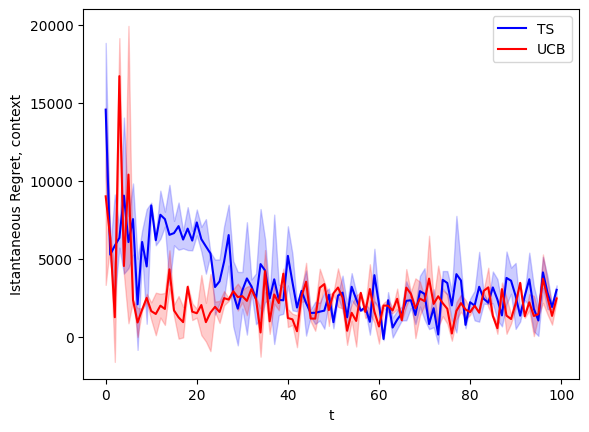

In [13]:
# CONTEXT REGRET IST
mean_inst_regret_ts = opt - np.mean(np.array(context_ts_rewards_per_experiment), axis=0)
std_inst_regret_ts = np.std(opt - np.array(context_ts_rewards_per_experiment), axis=0)

mean_inst_regret_ucb = opt - np.mean(np.array(context_ucb_rewards_per_experiment), axis=0)
std_inst_regret_ucb = np.std(opt - np.array(context_ucb_rewards_per_experiment), axis=0)

plt.ylabel("Istantaneous Regret, context")
plt.xlabel("t")
plt.plot(mean_inst_regret_ts, 'b', label='TS')
plt.fill_between(range(len(mean_inst_regret_ts)), mean_inst_regret_ts - std_inst_regret_ts, mean_inst_regret_ts + std_inst_regret_ts, alpha=0.2, color='b')

plt.plot(mean_inst_regret_ucb, 'r', label='UCB')
plt.fill_between(range(len(mean_inst_regret_ucb)), mean_inst_regret_ucb - std_inst_regret_ucb, mean_inst_regret_ucb + std_inst_regret_ucb, alpha=0.2, color='r')
#plt.plot(np.mean(opt - np.array(ts_rewards_per_experiment), axis=0), 'r', label='TS')
plt.legend()
plt.show()

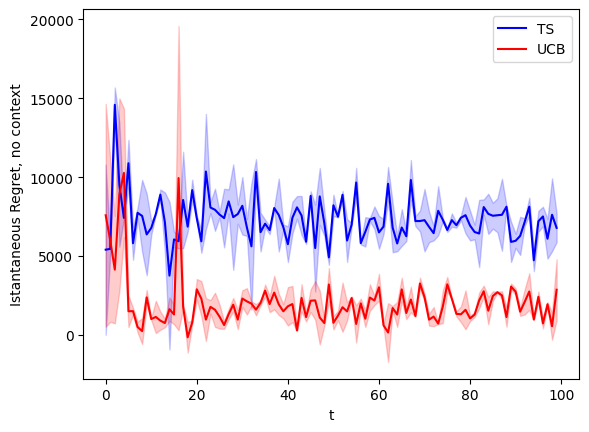

In [14]:
# NO CONTEXT REGRET IST
mean_inst_regret_ts = opt - np.mean(np.array(no_context_ts_rewards_per_experiment), axis=0)
std_inst_regret_ts = np.std(opt - np.array(no_context_ts_rewards_per_experiment), axis=0)

mean_inst_regret_ucb = opt - np.mean(np.array(no_context_ucb_rewards_per_experiment), axis=0)
std_inst_regret_ucb = np.std(opt - np.array(no_context_ucb_rewards_per_experiment), axis=0)

plt.ylabel("Istantaneous Regret, no context")
plt.xlabel("t")
plt.plot(mean_inst_regret_ts, 'b', label='TS')
plt.fill_between(range(len(mean_inst_regret_ts)), mean_inst_regret_ts - std_inst_regret_ts, mean_inst_regret_ts + std_inst_regret_ts, alpha=0.2, color='b')

plt.plot(mean_inst_regret_ucb, 'r', label='UCB')
plt.fill_between(range(len(mean_inst_regret_ucb)), mean_inst_regret_ucb - std_inst_regret_ucb, mean_inst_regret_ucb + std_inst_regret_ucb, alpha=0.2, color='r')
#plt.plot(np.mean(opt - np.array(ts_rewards_per_experiment), axis=0), 'r', label='TS')
plt.legend()
plt.show()